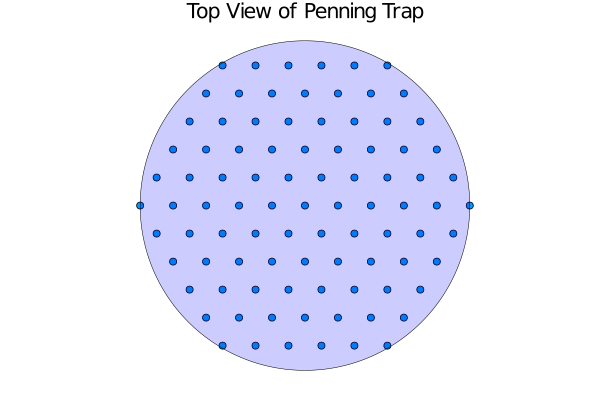

In [1]:
interionic_spacing = .2
up_modifier = sqrt(3)/2 * interionic_spacing
over_modifer = 1/2 * interionic_spacing
points_inside_circle = []
digits = 2
radius = 1
function gen_points(pt, points_inside_circle, x, y)
    pt = [round(pt[1], digits=digits), round(pt[2], digits=digits)]
    if pt in points_inside_circle || pt[1]^2 + pt[2]^2 > radius^2
        return
    else
        push!(points_inside_circle, pt)
        push!(x, pt[1])
        push!(y, pt[2])
        gen_points([pt[1] + over_modifer, pt[2] - up_modifier], points_inside_circle, x, y)
        gen_points([pt[1] - over_modifer, pt[2] - up_modifier], points_inside_circle, x, y)
        gen_points([pt[1] - over_modifer, pt[2] + up_modifier], points_inside_circle, x, y)
        gen_points([pt[1] + over_modifer, pt[2] + up_modifier], points_inside_circle, x, y)
        gen_points([pt[1] + interionic_spacing, pt[2]], points_inside_circle, x, y)
        gen_points([pt[1] + interionic_spacing, pt[2]], points_inside_circle, x, y)
        gen_points([pt[1] - interionic_spacing, pt[2]], points_inside_circle, x, y)
        return points_inside_circle, x, y
    end
end
pairs, x, y = gen_points([0, 0], [], [], [])
function circleShape(h, k, r)
    θ = LinRange(0, 2*π, 500)
    h .+ r*sin.(θ), k .+ r*cos.(θ)
end
using Plots
gr() # We will continue onward using the GR backend
plot(x, y, seriestype = :scatter, title = "Top View of Penning Trap")
plot!(circleShape(0, 0, 1), seriestype = [:shape,], lw = .5, c=:blue, lincolor = :black, legend=false, fillalpha=.2, aspect_ratio = 1, axis=nothing, border=:none)

In [2]:
function plot_triangles_across_unit_disk(f, x, y)
    infids = []
    ψ1s = []
    ψ2s = []
    for (i, xx) in enumerate(x)
        print(i)
        ρ = sqrt(xx^2 + y[i]^2)
        ϕ = atan(y[i], xx)
        infid, ψ1, ψ2 = f(ρ, ϕ)
        push!(infids, infid)
        push!(ψ1s, ψ1)
        push!(ψ2s, ψ2)
        end
    infids, ψ1s, ψ2s
end
# function plot_triangles_across_unit_disk(f, x, y)
#     ψ1s = []
#     for (i, xx) in enumerate(x)
#         print(i)
#         ρ = sqrt(xx^2 + y[i]^2)
#         ϕ = atan(y[i], xx)
#         ψ1 = f(ρ, ϕ)
#         push!(ψ1s, ψ1)
#         end
#    ψ1s
# end

plot_triangles_across_unit_disk (generic function with 1 method)

In [474]:
using SpecialFunctions
using QuantumOptics

function fidelity(ρ, σ)
    print(ρ, σ)
    tr(sqrt(sqrt(ρ) * σ * sqrt(ρ)))^(1/2)
end

function R(n::Int64, m::Int64, ρ::Float64)
    if (n - m) % 2 != 0
        0
    else
        function summand(k)
            n = big(n)
            k = big(k)
            (-1)^k * factorial(n-k)/(factorial(k)*factorial(Int((n+m)/2) - k)*factorial(Int((n-m)/2) - k))*(ρ)^(n-2*k)
        end
        mapreduce(summand, +, Array(range(0, stop=Int((n-m)/2), step=1)))
    end
end

function unpack_zernike(zernike_coefficients_even, zernike_coefficients_odd, ρ, ω, t)
    Pevens = []
    eventuples = []
    for (m, zeven) in enumerate(zernike_coefficients_even)
        meven = m - 1
        push!(Pevens, [zeven[i] * R(i-1, meven, ρ) for i in Array(range(1, length(zeven), step=1))])
    end
    for i in range(1, length(Pevens), step=1)
        rotationeven = - (i - 1) * ω * t
        total = sum(Pevens[i])
        push!(eventuples, (i - 1, total, rotationeven))
    end
    eventuples # No odd tuples, so we'll leave it simple. (In fact, only m=0 again but we'll test this.)
end

toarray(s::Union{Set, Array}) = [toarray.(s)...]
toarray(v::Number) = v

toarray (generic function with 2 methods)

In [475]:
r2 = .6
r1 = .4
function Q(n::Int64, r2::Float64, r1::Float64)
    if n % 2 != 0
        0
    else
        function summand(k)
            n = big(n)
            k = big(k)
            (-1)^k * factorial(n-k)/(factorial(k)*factorial(big(Int(n/2 - k)))*factorial(big(Int(n/2 - k))))*((r2)^(n-2*k + 1)-(r1)^(n-2*k + 1))/(n-2k+1)
        end
        mapreduce(summand, +, Array(range(0, stop=Int((n)/2), step=1)))
    end

        end

function R(n::Int64, m::Int64, ρ::Float64)
    if (n - m) % 2 != 0
        0
    else
        function summand(k)
            n = big(n)
            k = big(k)
            (-1)^k * factorial(n-k)/(factorial(k)*factorial(Int((n+m)/2) - k)*factorial(Int((n-m)/2) - k))*(ρ)^(n-2*k)
        end
        mapreduce(summand, +, Array(range(0, stop=Int((n-m)/2), step=1)))
    end
end


R (generic function with 1 method)

In [293]:
#[(i + 1)*Q(i, r2, r1) for i in range(0, 100, step=1)]

In [294]:
coefficients = [0.2, 0., -0.0986667, 0., -0.022976, 0., 0.0781806, 0., -0.0487342, 
0., -0.01236, 0., 0.0425507, 0., -0.0263967, 0., -0.00532531, 0., 
0.0191911, 0., -0.0113529, 0., -0.000319994, 0., 0.00334532, 0., 
-0.00150927, 0., 0.00266453, 0., -0.00564976, 0., 0.00371128, 0.,
0.00365755, 0., -0.00861338, 0., 0.00514161, 0., 0.0030191, 0., 
-0.00715006, 0., 0.00403216, 0., 0.0014179, 0., -0.00338915, 0., 
0.00178983, 0., -0.000352217, 0., 0.000572278, 0., -0.000370555, 0., 
-0.00161038, 0., 0.00320668, 0., -0.00168678, 0., -0.00198314, 0., 
0.00386709, 0., -0.00193623, 0., -0.00148342, 0., 0.00278418, 0., 
-0.00134546, 0., -0.000450159, 0., 0.000785755, 0., -0.000382714, 0., 
0.000621396, 0., -0.00113039, 0., 0.000475921, 0., 0.00128836, 0., 
-0.00220249, 0., 0.000922589, 0., 0.0013266, 0., -0.00215031, 0., 
0.000888539, 0., 0.000794939, 0., -0.00119665, 0., 0.000508962, 0., 
-0.0000192277, 0., 0.0001079, 0., 0.0000196976, 0., -0.000740927, 0., 
0.00115972, 0., -0.000359329, 0., -0.00107136, 0., 0.00155516, 0., 
-0.000506112, 0., -0.000905712, 0., 0.00122522, 0., -0.000420243, 0., 
-0.000360066, 0., 0.0004148, 0., -0.000192729, 0., 0.000296572, 0., 
-0.000463473, 0., 0.000053083, 0., 0.000769603, 0., -0.00102475, 0.,
0.000218623, 0., 0.000867273, 0., -0.00106993, 0., 0.000262475, 0., 
0.000575562, 0., -0.000645642, 0., 0.000201014, 0., 0.0000512109, 0., 
6.63837*10^-6, 0., 0.0000854328, 0., -0.000458546, 0., 0.000577412, 
0., -0.0000286677, 0., -0.000730063, 0., 0.000829532, 0., 
-0.000104009, 0., -0.00065953, 0., 0.000691181, 0., -0.000129189, 0., 
-0.000300664, 0., 0.000267442, 0., -0.000112741, 0., 0.00016899, 0., 
-0.000225201, 0., -0.0000712962, 0., 0.000534046, 0., -0.000564832, 
0., -0.000020019]

201-element Array{Float64,1}:
  0.2
  0.0
 -0.0986667
  0.0
 -0.022976
  0.0
  0.0781806
  0.0
 -0.0487342
  0.0
 -0.01236
  0.0
  0.0425507
  ⋮
  0.0
  0.00016899
  0.0
 -0.000225201
  0.0
 -7.12962e-5
  0.0
  0.000534046
  0.0
 -0.000564832
  0.0
 -2.0019e-5

In [295]:
max_n = 40
function sample_across_unit_disk(f, discretization)
    x = y = Array(range(-1, 1, length=discretization))
    z = Array{typeof(f(0.,0.))}(UndefInitializer(), length(x), length(y))
    for (i, xx) in enumerate(x)
        for (j, yy) in enumerate(y)
            if xx^2 + yy^2 > .9
                if typeof(f(0.,0.)) == Tuple{Float64,Float64}
                    z[i, j] = (0.,0.)
                else
                    z[i, j] = 0.
                end
            else
                ρ = sqrt(xx^2 + yy^2)
                ϕ = atan(yy, xx)
                res = f(ρ, ϕ)
                z[i, j] = res
            end
        end
    end
    x, y, z
end
function recon(ρ, ϕ)
    #sum([(i + 1)*Q(i, r2, r1)*R(i,0,ρ) for i in range(0, max_n, step=1)])
    sum([(i + 1)*coefficients[i+1]*R(i,0,ρ) for i in range(0, max_n, step=1)])
end

xx, yy, samples =  sample_across_unit_disk(recon, 50)

([-1.0, -0.9591836734693877, -0.9183673469387755, -0.8775510204081632, -0.8367346938775511, -0.7959183673469388, -0.7551020408163265, -0.7142857142857143, -0.673469387755102, -0.6326530612244898  …  0.6326530612244898, 0.673469387755102, 0.7142857142857143, 0.7551020408163265, 0.7959183673469388, 0.8367346938775511, 0.8775510204081632, 0.9183673469387755, 0.9591836734693877, 1.0], [-1.0, -0.9591836734693877, -0.9183673469387755, -0.8775510204081632, -0.8367346938775511, -0.7959183673469388, -0.7551020408163265, -0.7142857142857143, -0.673469387755102, -0.6326530612244898  …  0.6326530612244898, 0.673469387755102, 0.7142857142857143, 0.7551020408163265, 0.7959183673469388, 0.8367346938775511, 0.8775510204081632, 0.9183673469387755, 0.9591836734693877, 1.0], BigFloat[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

In [122]:
recon(.1, 0.)

0.09810951713109387083800051277277628064885314089057031787661148787163560612825908

In [116]:
recon(0., 0.)

-0.23007404799999996332371399176963677746243774890899658203125

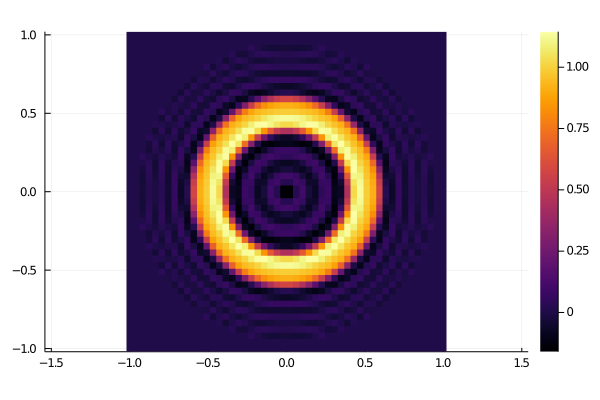

In [123]:
plot(heatmap(xx, yy, samples), cm=:ice, aspectratio=true)

In [482]:
[1 1; 1 1]

2×2 Array{Int64,2}:
 1  1
 1  1

In [528]:
Γ = 1/62
ω = 2*π*180E3
θ = 0.;
b = SpinBasis(1//2)
ψ0 = 1/sqrt(2) * (spindown(b) + spinup(b))
max_n = 30
scale = 1
zernikeeven = [[Q(i, r2, r1) for i in range(0, 10, step=1)]]
zernikeodd = []
amp = .5
μ = 0
order =  0

function infidelity_across_disk(F1, F2)
    function infidelity_polar(ρ, ϕ)
        ψ1 = F1(ρ, ϕ).data
        if r1 < ρ < r2
            ψ1 = 1/2 * [1 -1 ; -1 1]
        else
            ψ1 = 1/2 * [1 1 ; 1 1]
        end
        ψ2 = F2(ρ, ϕ).data
        infid = 1 - real(fidelity(ψ1, ψ2))
    return infid, ψ1, ψ2
    end
end

function across_disk(F1)
    function infidelity_polar(ρ, ϕ)
        ψ1 = F1(ρ, ϕ).data
    return ψ1
    end
end

function annulus(a, b)
    function rtn(ρ, ϕ)
        if a < ρ < b
            1
        else
            0
        end
    end
end


U = 2 * π * 10E3
evolution_time = π/(2*U*amp)

step_size = evolution_time/1
T = [0.0:step_size:evolution_time;];

function annulus_spin_profile(ρ, ϕ)
    ψ0 = 1/sqrt(2) * (spindown(b) + spinup(b))
    H(t, _) = U * sin(amp*annulus(r1, r2)(ρ, ϕ)) * sigmaz(b), [], []
    _, ψ = timeevolution.master_dynamic(T, ψ0, H)
    last(ψ)
end
function evolution_evaluator_factory(ψ0, T, zernikeeven, zernikeodd, U, ψ, μ, ω, b)
    function evaluator(ρ, ϕ)
        H(t, _) = H_odf(ρ, ϕ, t, zernikeeven, zernikeodd, U, ψ, μ, ω)*sigmaz(b), [sigmam(b)], [dagger(sigmam(b))]
        _, ψTARGET = timeevolution.master_dynamic(T, ψ0, H; rates=[Γ])
        last(ψTARGET)
    end
end
function H_odf(ρ, ϕ, t, zernike_coefficients_even, zernike_coefficients_odd, U, ψ, μ, ω)
    U * sin(amp*sum([(i + 1)*Q(i, r2, r1)*R(i,0,ρ) for i in range(0, max_n, step=1)])) 
end
exact_evolution_evaluator = evolution_evaluator_factory(ψ0, T, zernikeeven, [], U, θ, 0., ω, b)

(::var"#evaluator#618"{Ket{SpinBasis{1//2,Int64},Array{Complex{Float64},1}},Array{Float64,1},Array{Array{Real,1},1},Array{Any,1},Float64,Float64,Float64,Float64,SpinBasis{1//2,Int64}}) (generic function with 1 method)

In [529]:
evolution_time

4.9999999999999996e-5

In [530]:
ρ = .5
annulus(r1, r2)(ρ, 0) - sum([(i + 1)*Q(i, r2, r1)*R(i,0,ρ) for i in range(0, max_n, step=1)])

-0.1427479936692488691393440881926701603384405306287777224355517446952035238232954

In [531]:
evolution_time

4.9999999999999996e-5

In [532]:
# annulus_vals = plot_triangles_across_unit_disk(across_disk(annulus_spin_profile), x, y);

In [533]:
infid, annulus_vals, exact = plot_triangles_across_unit_disk(infidelity_across_disk(exact_evolution_evaluator, annulus_spin_profile), x, y);

1[0.5 0.5; 0.5 0.5]Complex{Float64}[0.4999999999999999 + 0.0im 0.4999999999999999 + 0.0im; 0.4999999999999999 + 0.0im 0.4999999999999999 + 0.0im]2[0.5 0.5; 0.5 0.5]Complex{Float64}[0.4999999999999999 + 0.0im 0.4999999999999999 + 0.0im; 0.4999999999999999 + 0.0im 0.4999999999999999 + 0.0im]3[0.5 0.5; 0.5 0.5]Complex{Float64}[0.4999999999999999 + 0.0im 0.4999999999999999 + 0.0im; 0.4999999999999999 + 0.0im 0.4999999999999999 + 0.0im]4[0.5 -0.5; -0.5 0.5]Complex{Float64}[0.4999999999999999 + 0.0im -0.4958276622395652 - 0.06445654019623116im; -0.4958276622395652 + 0.06445654019623116im 0.4999999999999999 + 0.0im]5[0.5 0.5; 0.5 0.5]Complex{Float64}[0.4999999999999999 + 0.0im 0.4999999999999999 + 0.0im; 0.4999999999999999 + 0.0im 0.4999999999999999 + 0.0im]6[0.5 0.5; 0.5 0.5]Complex{Float64}[0.4999999999999999 + 0.0im 0.4999999999999999 + 0.0im; 0.4999999999999999 + 0.0im 0.4999999999999999 + 0.0im]7[0.5 0.5; 0.5 0.5]Complex{Float64}[0.4999999999999999 + 0.0im 0.4999999999999999 + 0.0im; 0.4

[0.5 -0.5; -0.5 0.5]Complex{Float64}[0.4999999999999999 + 0.0im -0.4958276622395652 - 0.06445654019623116im; -0.4958276622395652 + 0.06445654019623116im 0.4999999999999999 + 0.0im]62[0.5 0.5; 0.5 0.5]Complex{Float64}[0.4999999999999999 + 0.0im 0.4999999999999999 + 0.0im; 0.4999999999999999 + 0.0im 0.4999999999999999 + 0.0im]63[0.5 -0.5; -0.5 0.5]Complex{Float64}[0.4999999999999999 + 0.0im -0.4958276622395652 - 0.06445654019623116im; -0.4958276622395652 + 0.06445654019623116im 0.4999999999999999 + 0.0im]64[0.5 0.5; 0.5 0.5]Complex{Float64}[0.4999999999999999 + 0.0im 0.4999999999999999 + 0.0im; 0.4999999999999999 + 0.0im 0.4999999999999999 + 0.0im]65[0.5 0.5; 0.5 0.5]Complex{Float64}[0.4999999999999999 + 0.0im 0.4999999999999999 + 0.0im; 0.4999999999999999 + 0.0im 0.4999999999999999 + 0.0im]66[0.5 0.5; 0.5 0.5]Complex{Float64}[0.4999999999999999 + 0.0im 0.4999999999999999 + 0.0im; 0.4999999999999999 + 0.0im 0.4999999999999999 + 0.0im]67[0.5 -0.5; -0.5 0.5]Complex{Float64}[0.4999999999999

In [534]:
zannulus = [real(tr([[0, 1] [1, 0]] * s)) for s in annulus_vals];

In [535]:
zseq  = [real(tr([[0, 1] [1, 0]] * s)) for s in exact];

In [536]:
# using Plots
# #plot(x, y, seriestype = :scatter, title = "Top View of Penning Trap")
# scatter(x, y, marker_z = 100*infids,  c = :heat)
# plot!(circleShape(0, 0, 1), seriestype = [:shape,], lw = .5, c=:blue, lincolor = :black, legend=false, fillalpha=0, aspect_ratio = 1, axis=nothing, border=:none, title="Log Infidelity")


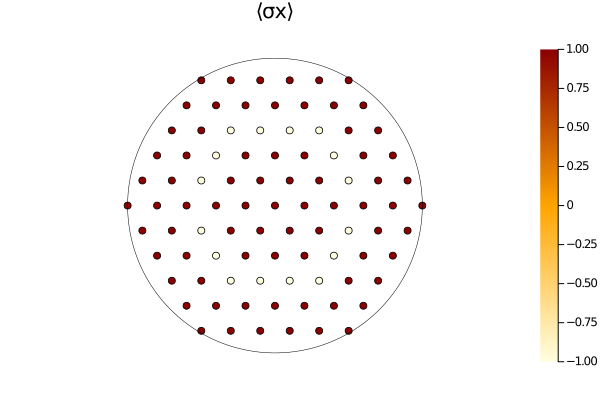

In [537]:
scatter(x, y, marker_z = zannulus,  c = :heat)
plot!(circleShape(0, 0, 1), seriestype = [:shape,], lw = .5, c=:blue, lincolor = :black, legend=false, fillalpha=0, aspect_ratio = 1, axis=nothing, border=:none, title="⟨σx⟩")

In [538]:
maximum(zannulus)

1.0

In [539]:
minimum(zannulus)

-1.0

In [540]:
maximum(zseq)

0.9999999999999998

In [541]:
minimum(zseq) # Either numerical, or truncation error. Additionally, this is NOT a good thing to look at. When I
# (accidentally) flip nearby ions by using twice the amplitude, it still looks good.

-0.9916553244791304

In [542]:
#findmax(zseq)


In [543]:
#fidelity(annulus_vals[45], exact[45])

In [544]:
#annulus_vals[45]

In [545]:
#plot(zseq)

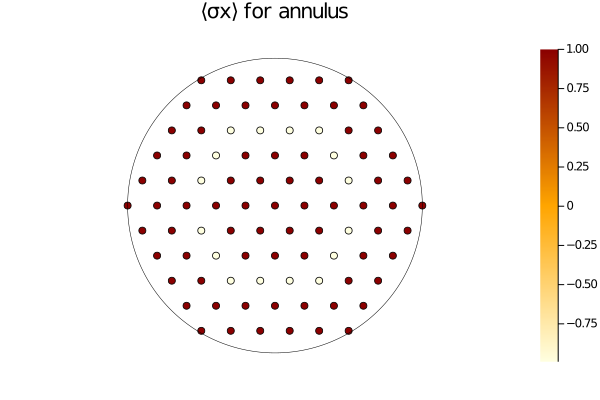

In [546]:
scatter(x, y, marker_z = zseq,  c = :heat)
plot!(circleShape(0, 0, 1), seriestype = [:shape,], lw = .5, c=:blue, lincolor = :black, legend=false, fillalpha=0, aspect_ratio = 1, axis=nothing, border=:none, title="⟨σx⟩ for annulus")

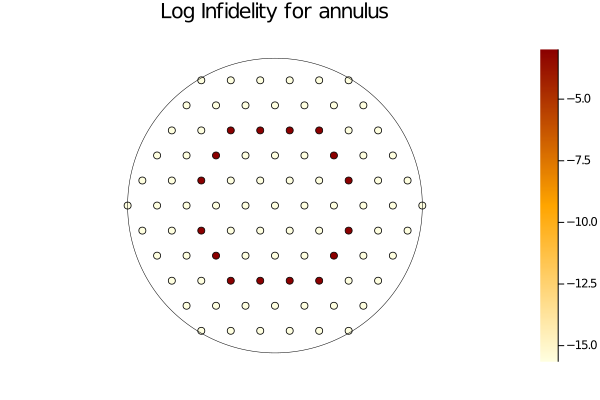

In [549]:
scatter(x, y, marker_z = log.(10, infid),  c = :heat)
plot!(circleShape(0, 0, 1), seriestype = [:shape,], lw = .5, c=:blue, lincolor = :black, legend=false, fillalpha=0, aspect_ratio = 1, axis=nothing, border=:none, title="Log Infidelity for annulus")

In [548]:
maximum(infid)

0.0010447204614200123